# Sales Data Analysis

Unguided study project using a [practice dataset](https://www.kaggle.com/datasets/knightbearr/sales-product-data) as published on Kaggle.

Primary goal (study goal) is finding the way to group rather granular available data to be able to draw some conclusions upon it.

Project goals are establishing the following:
- highest money-making categories (assuming equal margins relative to unit sale price), i.e. product groups that brought in the most gross revenue;
- most profitable territories/cities (by gross revenue);
- most profitable months;
- most common order hours; 
- attempting to point out territories/cities with suspiciously low revenue (for instance in per capita numbers), which may not be feasible given the limited scope of a study project;
- patterns of goods bundling up.

In a realistic setting, findings could be used to optimise advertisement strategy or logistics.

On a separate note, despite the dataset being rather clean (much more granularity and inconsistency in data inputs would be expected in a work environment), the number of questions that can be answered without combining it with differently structured datasets that might be available from other departments (info on stock, shelf placing/online store recommendation emphasis, etc) is very limited and would rather serve to highlight a potential issue/opportunity than provide an answer.

# I. Reading in and grouping data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [3]:
#our monthly data tables extracted into a subfolder for this to work

dataset_list = os.listdir('./Data/')
dataset_list

['Sales_April_2019.csv',
 'Sales_August_2019.csv',
 'Sales_December_2019.csv',
 'Sales_February_2019.csv',
 'Sales_January_2019.csv',
 'Sales_July_2019.csv',
 'Sales_June_2019.csv',
 'Sales_March_2019.csv',
 'Sales_May_2019.csv',
 'Sales_November_2019.csv',
 'Sales_October_2019.csv',
 'Sales_September_2019.csv']

In [4]:
data = pd.DataFrame()
for table in dataset_list:
    temp = pd.read_csv('./Data/' + table, parse_dates = ['Order Date'])
    data = pd.concat([data, temp])

data = data.sort_values(by = 'Order Date').reset_index(drop = True)
data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,147268,Wired Headphones,1,11.99,01/01/19 03:07,"9 Lake St, New York City, NY 10001"
1,148041,USB-C Charging Cable,1,11.95,01/01/19 03:40,"760 Church St, San Francisco, CA 94016"
2,149343,Apple Airpods Headphones,1,150,01/01/19 04:56,"735 5th St, New York City, NY 10001"
3,149964,AAA Batteries (4-pack),1,2.99,01/01/19 05:53,"75 Jackson St, Dallas, TX 75001"
4,149350,USB-C Charging Cable,2,11.95,01/01/19 06:03,"943 2nd St, Atlanta, GA 30301"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


It seems we have a few hundred lines where all values are missing, should be verified and dropped. Besides, we'll likely need total amount paid and less granular address (will try exact index match first).

In [6]:
mask = data.isnull().any(axis=1)
mask.value_counts() # .any flags the row if any column value fits the criteria

False    186305
True        545
dtype: int64

In [7]:
#number of rows with at least one missing value is exactly equal to number of missing values in each row, i.e. safe to drop

data = data[mask == False] #could use dropna, but we had a mask already
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186305 entries, 0 to 186304
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


In [8]:
#'Order Date' should've been datetime
#besides running .astype() on other numeric columns caused curious errors at this point

data[data['Order ID'] == 'Order ID'] #this value was listed as 'invalid base' for int conversion

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185950,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185951,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185952,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185953,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185954,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
186300,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
186301,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
186302,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
186303,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [9]:
data = data[data['Order ID'] != 'Order ID']
data.shape

(185950, 6)

In [10]:
#none of the below caused errors, which should rule out non-numeric values
#separate check for numeric outliers will be performed later

data['Order ID'] = data['Order ID'].astype(int)
data['Quantity Ordered'] = data['Quantity Ordered'].astype(int)
data['Price Each'] = data['Price Each'].astype(float)
data['Cost'] = data['Quantity Ordered']*data['Price Each']
data['Order Date'] = pd.to_datetime(data['Order Date']) #this took surprisingly long to complete
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 185949
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int32         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int32         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
 6   Cost              185950 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), object(2)
memory usage: 9.9+ MB


In [11]:
data['Post Index'] = data['Purchase Address'].str.extract('(\w{2}\s\d{4}\d?)')
data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Cost,Post Index
0,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001",11.99,NY 10001
1,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016",11.95,CA 94016
2,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001",150.00,NY 10001
3,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001",2.99,TX 75001
4,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301",23.90,GA 30301


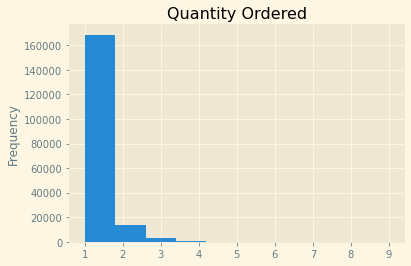

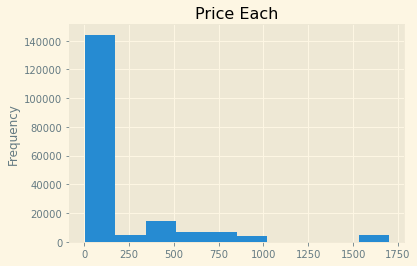

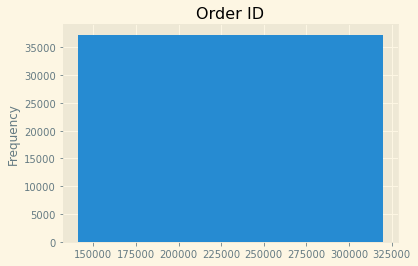

In [12]:
#below is a rough way of checking if there are any weird values in numeric columns

plt.style.use('Solarize_Light2')

data['Quantity Ordered'].plot.hist()
plt.title('Quantity Ordered')
plt.show()

data['Price Each'].plot.hist()
plt.title('Price Each')
plt.show()

data['Order ID'].plot.hist(bins = 5)
plt.title('Order ID')
plt.show()

Above graphs are exploratory, confirming (with boundary values primarily) that we have no suspicious values in data. As for shapes:
- uniform order ID distribution suggests there are no missing values, IDs were likely not assigned in some random patterns;
- quantity ordered is heavily right-skewed, with vast majority of customers bying only one item;
- price distribution doesn't tell much apart from the fact that the store doesn't seem to offer many popular goods priced within certain ranges, which is feasible with consumer electronics.

In [13]:
data['Post Index'].value_counts()

CA 94016    44732
CA 90001    29605
NY 10001    24876
MA 02215    19934
GA 30301    14881
TX 75001    14820
WA 98101    14732
OR 97035    10010
TX 73301     9905
ME 04101     2455
Name: Post Index, dtype: int64

Surprisingly small number of cities, replacing indices with names for readability.

In [14]:
#extracting cities by capturing a group in-between commas would've been faster...
#...but US cities tend to have duplicate names, indices are more reliable
index_mask = {'CA 94016':'San Francisco, CA', 'CA 90001':'Los Angeles, CA', 'NY 10001':'New York, NY',
              'MA 02215':'Boston, MA', 'GA 30301':'Atlanta, GA', 'TX 75001':'Addison, TX', 'WA 98101':'Seattle, WA',
             'OR 97035':'Lake Oswego, OR', 'TX 73301':'Austin, TX', 'ME 04101':'Portland, ME'}
data['Post Index'] = data['Post Index'].replace(index_mask)
data = data.rename(columns = {'Post Index':'City'})
#with larger datasets would've been better to use .copy() at transformation stages
data['City'].value_counts()

San Francisco, CA    44732
Los Angeles, CA      29605
New York, NY         24876
Boston, MA           19934
Atlanta, GA          14881
Addison, TX          14820
Seattle, WA          14732
Lake Oswego, OR      10010
Austin, TX            9905
Portland, ME          2455
Name: City, dtype: int64

In [15]:
data['Product'].unique()

array(['Wired Headphones', 'USB-C Charging Cable',
       'Apple Airpods Headphones', 'AAA Batteries (4-pack)', 'iPhone',
       'Lightning Charging Cable', '34in Ultrawide Monitor',
       'AA Batteries (4-pack)', 'Google Phone', 'Macbook Pro Laptop',
       'ThinkPad Laptop', '27in FHD Monitor',
       'Bose SoundSport Headphones', 'Flatscreen TV',
       '27in 4K Gaming Monitor', 'LG Dryer', '20in Monitor',
       'LG Washing Machine', 'Vareebadd Phone'], dtype=object)

At this point one would attempt to reduce data granularity for analysis by specifying categories and assigning them to individual products via regex masks (looking up 'cable', or 'battery', and assigning relevant value into the new Category columns). Surprisingly, this particular dataset has very few unique products, and further grouping is not advisable (USB-C and Lightning cables are already substantially different, especially with respect to bundling). Which renders the primary study goal moot, will proceed regardless though.

In [16]:
import datetime as dt
data['Month'] = data['Order Date'].dt.month
data['Hour'] = data['Order Date'].dt.hour
data.sample(5)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Cost,City,Month,Hour
16337,156206,Wired Headphones,1,11.99,2019-02-16 15:35:00,"861 8th St, Portland, OR 97035",11.99,"Lake Oswego, OR",2,15
73882,222002,Macbook Pro Laptop,1,1700.00,2019-06-05 20:56:00,"432 13th St, San Francisco, CA 94016",1700.00,"San Francisco, CA",6,20
50597,190092,Apple Airpods Headphones,1,150.00,2019-04-23 16:14:00,"960 Madison St, Portland, ME 04101",150.00,"Portland, ME",4,16
181119,304056,AA Batteries (4-pack),2,3.84,2019-12-25 23:03:00,"531 Forest St, San Francisco, CA 94016",7.68,"San Francisco, CA",12,23
31500,172050,AA Batteries (4-pack),2,3.84,2019-03-21 03:04:00,"701 11th St, San Francisco, CA 94016",7.68,"San Francisco, CA",3,3


# II. Highest money-making categories (products)

In [17]:
revenue_per_product = data.groupby(by = 'Product')['Cost'].sum().sort_values(ascending = False)
revenue_per_product

Product
Macbook Pro Laptop            8037600.00
iPhone                        4794300.00
ThinkPad Laptop               4129958.70
Google Phone                  3319200.00
27in 4K Gaming Monitor        2435097.56
34in Ultrawide Monitor        2355558.01
Apple Airpods Headphones      2349150.00
Flatscreen TV                 1445700.00
Bose SoundSport Headphones    1345565.43
27in FHD Monitor              1132424.50
Vareebadd Phone                827200.00
20in Monitor                   454148.71
LG Washing Machine             399600.00
LG Dryer                       387600.00
Lightning Charging Cable       347094.15
USB-C Charging Cable           286501.25
Wired Headphones               246478.43
AA Batteries (4-pack)          106118.40
AAA Batteries (4-pack)          92740.83
Name: Cost, dtype: float64

In [18]:
revenue_per_product_pct = revenue_per_product*100/revenue_per_product.sum()
revenue_per_product_pct #percent convertion not necessary for the upcoming plot, but useful to see in an array

Product
Macbook Pro Laptop            23.302771
iPhone                        13.899730
ThinkPad Laptop               11.973659
Google Phone                   9.623091
27in 4K Gaming Monitor         7.059884
34in Ultrawide Monitor         6.829281
Apple Airpods Headphones       6.810703
Flatscreen TV                  4.191402
Bose SoundSport Headphones     3.901090
27in FHD Monitor               3.283148
Vareebadd Phone                2.398235
20in Monitor                   1.316677
LG Washing Machine             1.158528
LG Dryer                       1.123738
Lightning Charging Cable       1.006302
USB-C Charging Cable           0.830630
Wired Headphones               0.714595
AA Batteries (4-pack)          0.307661
AAA Batteries (4-pack)         0.268876
Name: Cost, dtype: float64

In [19]:
rpp_other = revenue_per_product_pct.drop(revenue_per_product_pct.index[:7]).sum()
rpp_pie = revenue_per_product_pct.drop(revenue_per_product_pct.index[8:]).rename(index={'Flatscreen TV': 'Other'})
rpp_pie.loc[['Other']] = rpp_other
rpp_pie

Product
Macbook Pro Laptop          23.302771
iPhone                      13.899730
ThinkPad Laptop             11.973659
Google Phone                 9.623091
27in 4K Gaming Monitor       7.059884
34in Ultrawide Monitor       6.829281
Apple Airpods Headphones     6.810703
Other                       20.500882
Name: Cost, dtype: float64

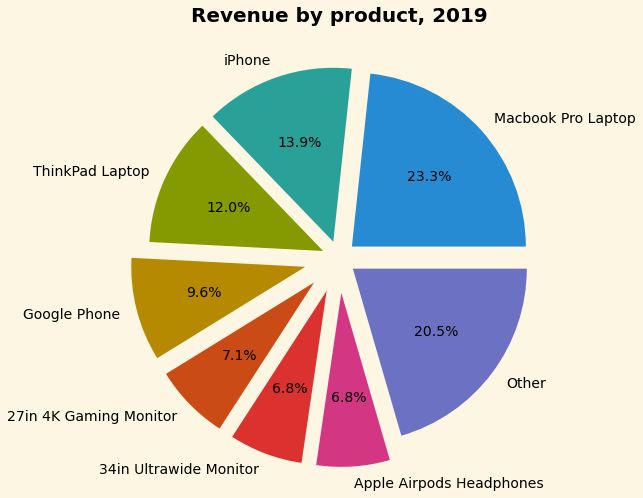

In [20]:
explode = [0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.1]

fig = plt.figure(figsize = [12,8])

rpp_pie.plot.pie(explode = explode,
                 autopct='%1.1f%%',
                 textprops={'fontsize': 14})
plt.ylabel('')
plt.title('Revenue by product, 2019',
          y = 1.03, size = 20, weight = 'bold')
plt.show()

Macbooks and iPhones + Airpods account for almost half our sales. Assuming the margins are comparable, running campaigns that stimulate renewal of their Apple products by customers, as well as watching out for other Apple dealers in the area/with access to our target audience, is advisable.

Given that in reality margins are not comparable, with Apple supposedly allowing for better margins, Apple products are by far the largest money-maker for the store. This does not, however, imply that opportunities to diversify product line on offer should be ignored - only highlights the current situation.

# III. Most and least profitable cities

In [21]:
revenue_per_city = data.groupby(by = 'City')['Cost'].sum().sort_values(ascending = False)
revenue_per_city

City
San Francisco, CA    8262203.91
Los Angeles, CA      5452570.80
New York, NY         4664317.43
Boston, MA           3661642.01
Atlanta, GA          2795498.58
Addison, TX          2767975.40
Seattle, WA          2747755.48
Lake Oswego, OR      1870732.34
Austin, TX           1819581.75
Portland, ME          449758.27
Name: Cost, dtype: float64

Background on cities and/or operational parameters of the store would be useful for some more insights, as such will look at per capita figures.

In [22]:
revenue_per_city_pc = revenue_per_city.copy()

pops = [874784, 3973000, 8380000, 689326, 497642, 15428, 741251, 39476, 965872, 66706] #googled rough population numbers
for i in range(10):
    revenue_per_city_pc.iloc[i] /= pops[i]
revenue_per_city_pc

City
San Francisco, CA      9.444850
Los Angeles, CA        1.372406
New York, NY           0.556601
Boston, MA             5.311916
Atlanta, GA            5.617489
Addison, TX          179.412458
Seattle, WA            3.706916
Lake Oswego, OR       47.389106
Austin, TX             1.883875
Portland, ME           6.742396
Name: Cost, dtype: float64

Those are some very weird figures. Presumably addresses act as delivery hubs for larger regions. Or, perhaps, citizens of Addison are indeed in dire need of ~40 times more laptops per capita than their compatriots. Or our store is the only outlet of its kind in Addison, and all the citizens and their suburban friends and extended relatives shop there.

As this is a study exercise, assuming the figures are meaningful and plotting them all below without changes.

Either way, New York, Los Angeles and Austin seem to be underperforming and warrant a closer look by the marketing team.

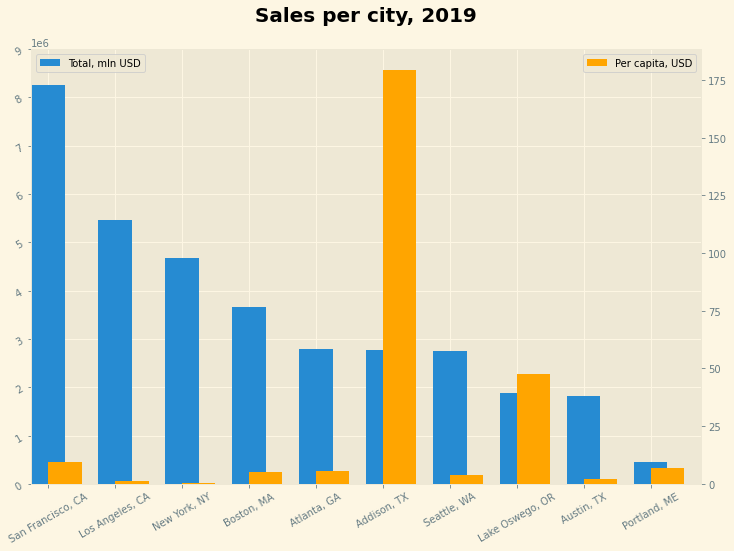

In [23]:
fig, ax1 = plt.subplots(figsize = [12,8])

ax2 = ax1.twinx()

revenue_per_city.plot.bar(ax = ax1, align = 'center', label = 'Total, mln USD')
revenue_per_city_pc.plot.bar(ax = ax2, align = 'edge', color = 'orange', label = 'Per capita, USD')

plt.title('Sales per city, 2019', y = 1.05, size = 20, weight = 'bold')
ax1.tick_params(which='major', labelrotation=30)
ax1.set_xlabel('')

ax1.set_ylim(top = 9000000)
ax1.legend(loc = 'upper left')
ax2.legend()

plt.grid(None)

plt.show()

# IV. Seasonality and common order hours

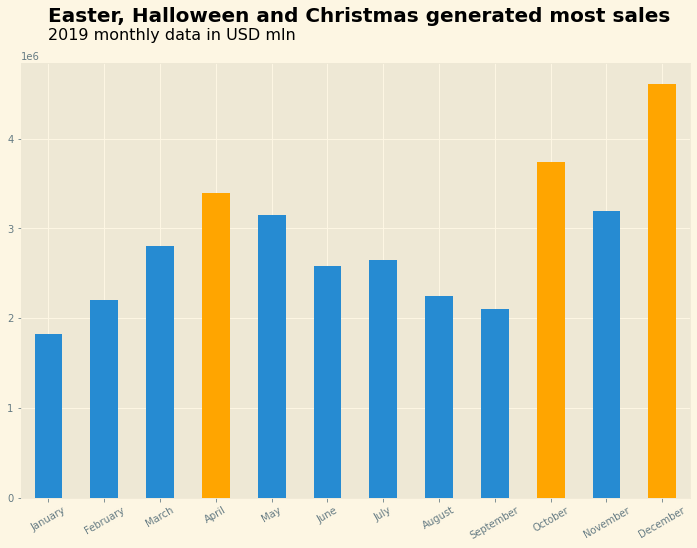

In [24]:
revenue_per_month = data.groupby(by = 'Month')['Cost'].sum()

plt.figure(figsize = [12,8])

#study note: there must be a better way to set individual colours; check .set_color
revenue_per_month.plot.bar(color = ['#268bd2', '#268bd2', '#268bd2', 'orange', '#268bd2', '#268bd2',
                                    '#268bd2', '#268bd2', '#268bd2', 'orange', '#268bd2', 'orange', ])

plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11],
           labels = ['January','February','March','April','May','June',
                                                           'July','August','September','October','November','December'],
          rotation = 30)

plt.xlabel('')
plt.text(x=0, y=5300000, s='Easter, Halloween and Christmas generated most sales', size = 20, weight = 'bold')
plt.text(x=0, y=5100000, s='2019 monthly data in USD mln', size = 16)

plt.show()

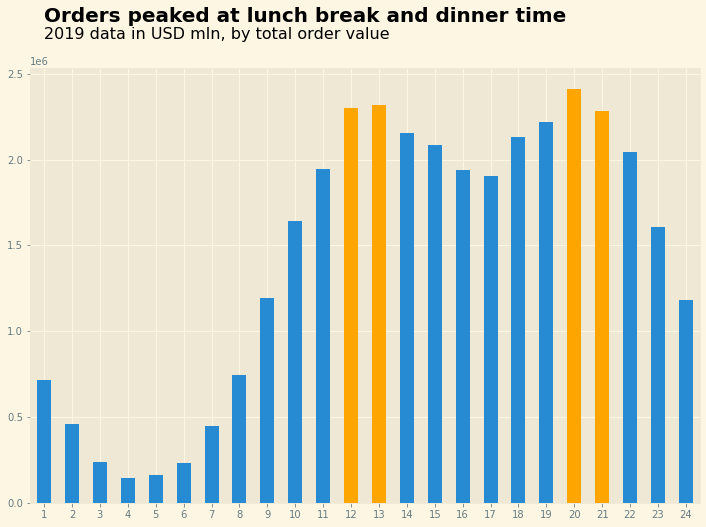

In [25]:
revenue_per_hour = data.groupby(by = 'Hour')['Cost'].sum()

plt.figure(figsize = [12,8])

revenue_per_hour.plot.bar(color = ['#268bd2', '#268bd2', '#268bd2', '#268bd2', '#268bd2', '#268bd2',
                                   '#268bd2', '#268bd2', '#268bd2', '#268bd2', '#268bd2', 'orange',
                                   'orange', '#268bd2', '#268bd2', '#268bd2', '#268bd2', '#268bd2',
                                   '#268bd2', 'orange', 'orange', '#268bd2', '#268bd2', '#268bd2', ])

plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
           labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
           rotation = 0)
plt.xlabel('')
           
plt.text(x=0, y=2800000, s='Orders peaked at lunch break and dinner time', size = 20, weight = 'bold')
plt.text(x=0, y=2700000, s='2019 data in USD mln, by total order value', size = 16)

plt.show()

These results could be expanded by looking at peak hours per month, as well as distinguishing between workdays, weekends and holidays, not to mention checking if there's a significant difference in-between workdays. All that analysis brings little additional value to a study project and will be skipped here.

# V. Bundling

As seen when exploring data, most of our orders included a single item, and most of the rest included only two items. As such, building a frequency table on purchased bundles should already provide sufficient information in case of the dataset analysed.

In [26]:
bundle_data = data[data['Order ID'].duplicated(keep = False)].copy().reset_index(drop = True)
bundle_data.head(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Cost,City,Month,Hour
0,144804,Wired Headphones,1,11.99,2019-01-01 07:29:00,"628 Lake St, New York City, NY 10001",11.99,"New York, NY",1,7
1,144804,iPhone,1,700.00,2019-01-01 07:29:00,"628 Lake St, New York City, NY 10001",700.00,"New York, NY",1,7
2,148074,USB-C Charging Cable,1,11.95,2019-01-01 11:25:00,"6 Johnson St, Atlanta, GA 30301",11.95,"Atlanta, GA",1,11
3,148074,Google Phone,1,600.00,2019-01-01 11:25:00,"6 Johnson St, Atlanta, GA 30301",600.00,"Atlanta, GA",1,11
4,148450,Lightning Charging Cable,1,14.95,2019-01-01 12:02:00,"761 Lakeview St, Dallas, TX 75001",14.95,"Addison, TX",1,12
5,148450,iPhone,1,700.00,2019-01-01 12:02:00,"761 Lakeview St, Dallas, TX 75001",700.00,"Addison, TX",1,12
6,144679,Google Phone,1,600.00,2019-01-01 12:51:00,"984 Lakeview St, San Francisco, CA 94016",600.00,"San Francisco, CA",1,12
7,144679,USB-C Charging Cable,1,11.95,2019-01-01 12:51:00,"984 Lakeview St, San Francisco, CA 94016",11.95,"San Francisco, CA",1,12
8,147451,Google Phone,1,600.00,2019-01-01 12:57:00,"229 Elm St, New York City, NY 10001",600.00,"New York, NY",1,12
9,147451,Wired Headphones,1,11.99,2019-01-01 12:57:00,"229 Elm St, New York City, NY 10001",11.99,"New York, NY",1,12


In [59]:
bundle_data['Bundle'] = bundle_data.groupby(by = 'Order ID')['Product'].transform(lambda x:', '.join(sorted(x)))
#study note: sorting above allowed ignoring more complex solutions with itertools.combinations()
#which surprisingly still treated differently ordered bundles as separate, and functioned differently
#(counting 2-item matches in 3-item bundles)

bundle_only_bundles = bundle_data[bundle_data['Order ID'].duplicated(keep = 'first')].copy().drop(columns = ['Product', 'Quantity Ordered', 'Price Each', 'Cost']).reset_index(drop = True)
bundle_only_bundles.head()

,Order ID,Order Date,Purchase Address,City,Month,Hour,Bundle
0,144804,2019-01-01 07:29:00,"628 Lake St, New York City, NY 10001","New York, NY",1,7,"Wired Headphones, iPhone"
1,148074,2019-01-01 11:25:00,"6 Johnson St, Atlanta, GA 30301","Atlanta, GA",1,11,"Google Phone, USB-C Charging Cable"
2,148450,2019-01-01 12:02:00,"761 Lakeview St, Dallas, TX 75001","Addison, TX",1,12,"Lightning Charging Cable, iPhone"
3,144679,2019-01-01 12:51:00,"984 Lakeview St, San Francisco, CA 94016","San Francisco, CA",1,12,"Google Phone, USB-C Charging Cable"
4,147451,2019-01-01 12:57:00,"229 Elm St, New York City, NY 10001","New York, NY",1,12,"Google Phone, Wired Headphones"


In [51]:
print(bundle_data.shape, bundle_only_bundles.shape)

(14649, 11) (7513, 7)


In [60]:
bundle_freq2 = bundle_data['Bundle'].value_counts()
bundle_freq2.head(10)

Lightning Charging Cable, iPhone                        1782
Google Phone, USB-C Charging Cable                      1736
Wired Headphones, iPhone                                 748
USB-C Charging Cable, Vareebadd Phone                    636
Google Phone, Wired Headphones                           622
Apple Airpods Headphones, iPhone                         598
Bose SoundSport Headphones, Google Phone                 338
Google Phone, USB-C Charging Cable, Wired Headphones     234
Vareebadd Phone, Wired Headphones                        220
AA Batteries (4-pack), Lightning Charging Cable          206
Name: Bundle, dtype: int64

In [62]:
bundle_freq_other = bundle_freq2.drop(bundle_freq2.index[:7]).sum()
bundle_freq_pie = bundle_freq2.drop(bundle_freq2.index[8:]).rename(index={'Google Phone, USB-C Charging Cable, Wired Headphones': 'Other'})
bundle_freq_pie.loc[['Other']] = bundle_freq_other
bundle_freq_pie

Lightning Charging Cable, iPhone            1782
Google Phone, USB-C Charging Cable          1736
Wired Headphones, iPhone                     748
USB-C Charging Cable, Vareebadd Phone        636
Google Phone, Wired Headphones               622
Apple Airpods Headphones, iPhone             598
Bose SoundSport Headphones, Google Phone     338
Other                                       8189
Name: Bundle, dtype: int64

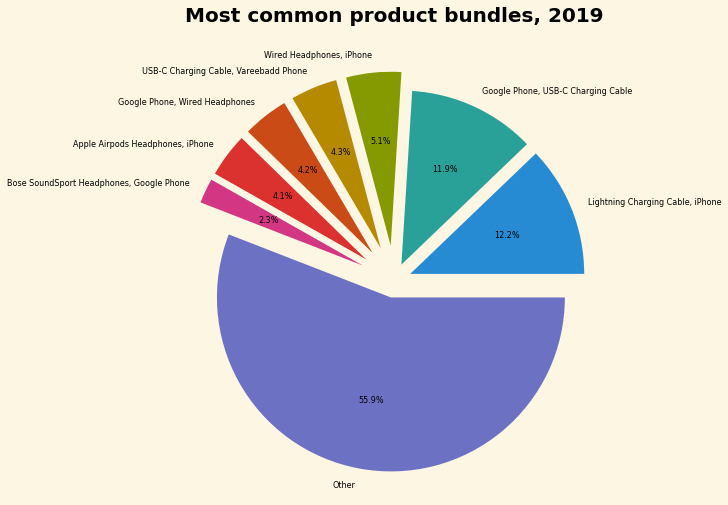

In [64]:
explode = [0.1,0.1,0.2,0.2,0.2,0.2,0.2,0.1]

fig = plt.figure(figsize = [15,8])

bundle_freq_pie.plot.pie(explode = explode,
                         autopct='%1.1f%%',
                         textprops={'fontsize': 8})
plt.ylabel('')
plt.title('Most common product bundles, 2019',
          y = 1.08, size = 20, weight = 'bold')
plt.show()

# VI. Conclusions

1. The store in question collects revenue primarily from selling Apple products.
2. Assuming that order address data is correct, New York, Los Angeles and Austin should be looked at as they're lagging behind in per-capita sales.
3. Sales are heavily skewed towards holiday seasons, most notably clustering around Easter, Halloween and Christmas, with a heavy drop in January.
4. Most orders are placed during lunch and at around dinner time. Morning hours, on the other hand, see little activity.
5. Bundle orders are rare, but most commonly include compatible charging cable or headphones being purchased along with the  smartphone.